In [21]:
%matplotlib inline
from matplotlib import rcParams, rcdefaults
from matplotlib.pyplot import subplots, style, hist, legend, plot, imshow, colorbar, title
from numpy import linspace
from scipy.optimize import curve_fit
import numpy as np
rcParams['image.aspect'] = 'auto'
rcParams['figure.figsize'] = (10,8)
style.use('fivethirtyeight')

# Loading data

In [2]:
from iuvs import io
reload(io)

NameError: name 'reload' is not defined

In [3]:
fname = io.l1b_filenames("cruisecal2-mode080-muv", stage=False)

In [4]:
fname

['/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T120028_v00_r00.fits.gz']

In [5]:
l1b = io.L1BReader(fname)

In [6]:
dark0 = l1b.detector_dark[0]
dark1 = l1b.detector_dark[1]
dark2 = l1b.detector_dark[2]

# Multiplicative comparison of darks

In [7]:
def myhist(data, **kwargs):
    hist(data.ravel(), 100, range=(0,5000), log=True, alpha=0.5, **kwargs)

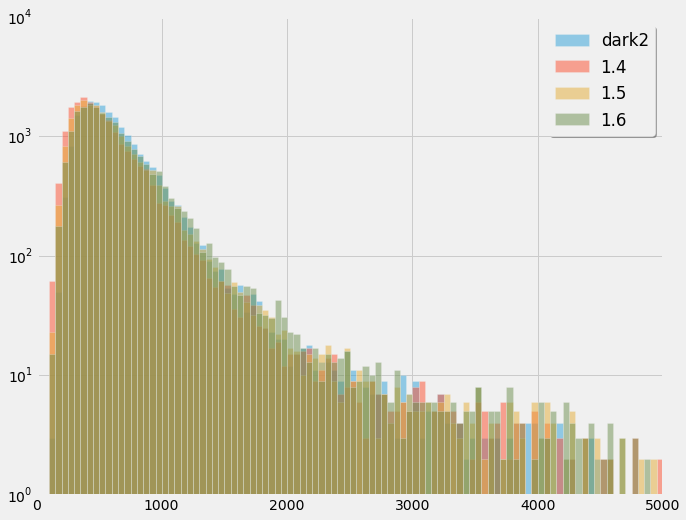

In [8]:
myhist(dark2, label='dark2')
for a in linspace(1.4,1.6, 3):
    myhist(dark1*a, label=str(a))
legend();

This looks promising, the shape of the histograms are getting very close with a simple multipication.

Below I compare how a spatially averaged spectral profile between the darks can be made look similar just with a multiplicative scaling.

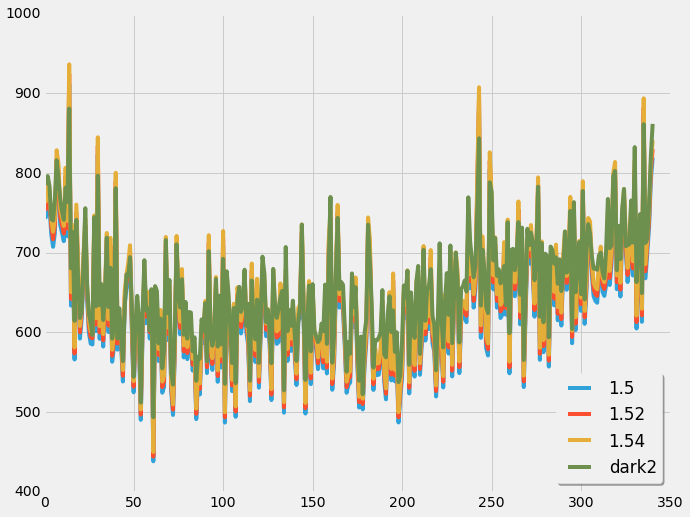

In [9]:
for a in [1.5,1.52, 1.54]:
    plot(a*dark1.mean(axis=0), label=str(a))
plot(dark2.mean(axis=0), label='dark2')
legend(loc='best');

#  Modeling the fit
In the old fashion way, one would define a model function and use a minimizer (here called `curve_fit` using least-square optimization) to find the parameters for which the model best approaches the data to recreate.

In our situation, the `model` is how to get from one dark to the other.

In [10]:
def multimodel(x, a):
    return a*x

In [11]:
def addmodel(x, a):
    return a+x

In [12]:
from scipy.optimize import curve_fit

Here I linearize all pixels for the darks to have simple 1D vectors of data to be matched with each other:

In [13]:
data_in = dark1.ravel()
data_out = dark2.ravel()

Now the fitting. `curve_fit` returns the coefficients as required by the model parameters above and the covariance matrix of the fit, with the errors for the coefficients given on the diagonal of that matrix.

In [23]:
mult_p0, mult_pcov = curve_fit(multimodel, data_in, data_out)
mult_perr = np.sqrt(np.diag(mult_pcov))

In [24]:
add_p0, add_pcov = curve_fit(addmodel, data_in, data_out)
add_perr = np.sqrt(np.diag(add_pcov))

I will now use a residual to define the quality of the fit, both as an absolute and as a ratio to the target data:

In [25]:
mult_residual = dark2 - multimodel(dark1, mult_p0)
add_residual = dark2 - addmodel(dark1, add_p0)

In [26]:
mult_fractional = (mult_residual/dark2)
add_fractional = (add_residual/dark2)

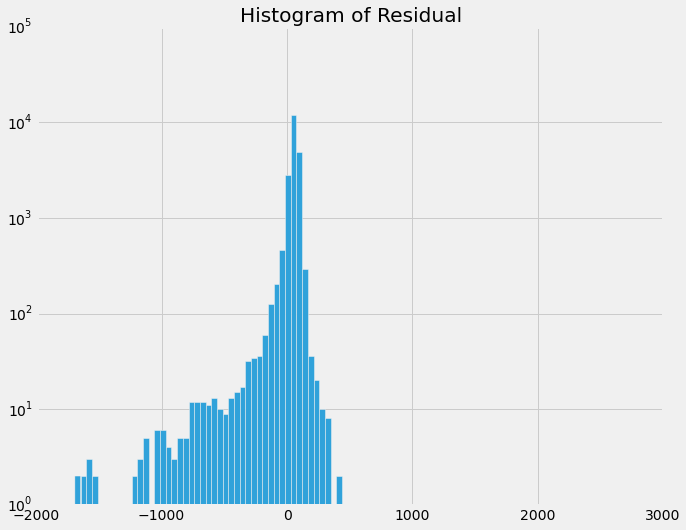

In [27]:
_, ax = subplots()
ax.hist(mult_residual.ravel(), 100, log=True);
ax.set_title('Histogram of Residual');

# Polynomial model
Using more advanced tools, I simply fit sets of polynomials with increasing degree `n` and apply this to the first dark vector.

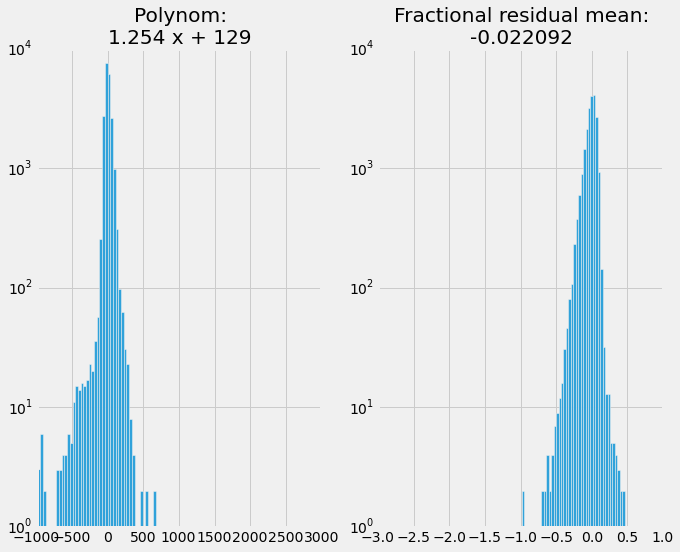

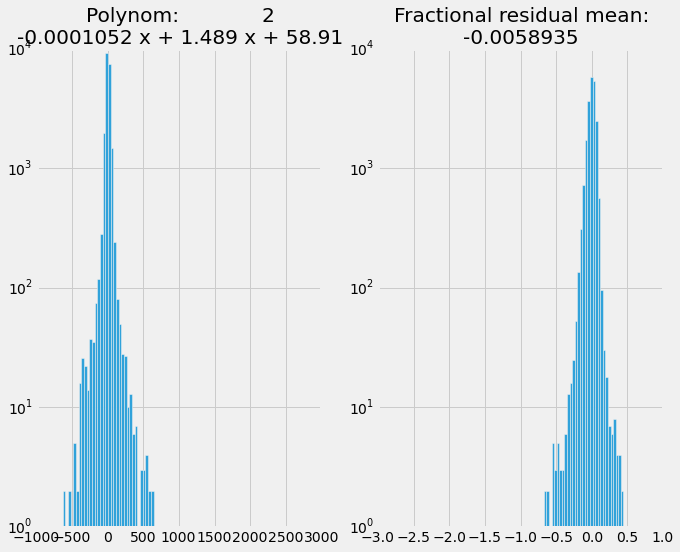

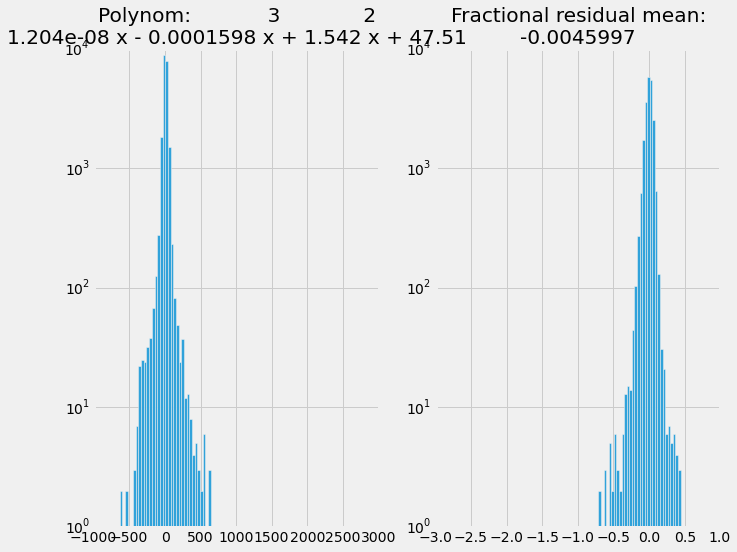

In [28]:
def do_polyfit(rank, dark_in, dark_out):
    z = np.polyfit(dark_in.ravel(), dark_out.ravel(), rank)
    poly = np.poly1d(z)
    residual = dark_out - poly(dark_in)
    fractional = residual/dark_out
    return poly, residual, fractional, poly(dark_in)

fitted_darks = []
residuals = []
for rank in range(1,4):
    poly, residual, fractional, fitted = do_polyfit(rank, dark1, dark2)
    residuals.append(residual)
    fitted_darks.append(fitted)
    fig, ax = subplots(ncols=2)
    ax[0].set_title("Polynom: {}".format(poly))
    ax[0].hist(residual.ravel(), 100, log=True)
    ax[1].hist(fractional.ravel(), 100, log=True)
#     ax[1].plot(fractional)
    ax[1].set_title("Fractional residual mean:\n{:.5}".format(fractional.mean()))

In [32]:
add_fractional

array([[ 0.06322204,  0.05757506,  0.01658746, ...,  0.08216836,
         0.13883949,  0.15225779],
       [-0.07600153,  0.01409307,  0.0720908 , ...,  0.13619717,
         0.19149351,  0.17792243],
       [ 0.03793507,  0.0102578 ,  0.02603896, ..., -0.17610253,
        -0.10097881,  0.07380817],
       ..., 
       [-0.05330422,  0.07611815, -0.23956201, ...,  0.18844905,
         0.12913692,  0.1926095 ],
       [-0.07196767,  0.1152291 ,  0.08356145, ...,  0.05658725,
         0.02354684,  0.04461514],
       [-0.08331549,  0.29086744,  0.08564077, ...,  0.12046236,
         0.06776   ,  0.15550553]])

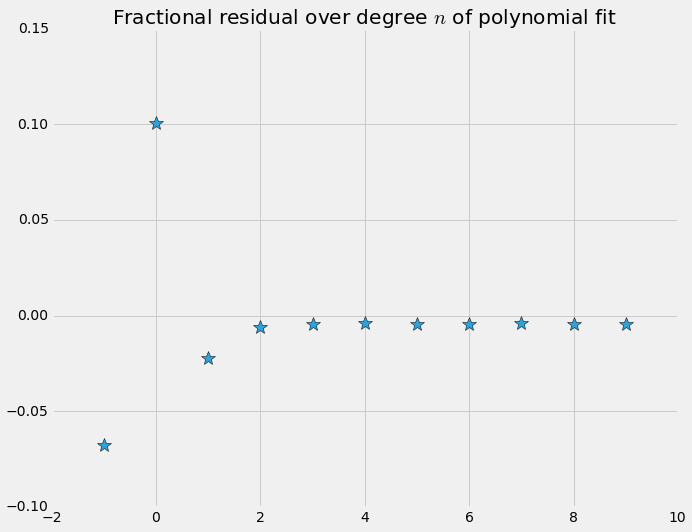

In [34]:
fig, ax = subplots()
frac_residuals = []
for rank in range(1,10):
    poly, residual, fractional, _ = do_polyfit(rank, data_in, data_out)
    frac_residuals.append(fractional.mean())
ax.plot([-1, 0] + list(range(1,10)), [add_fractional.mean(), mult_fractional.mean()]+frac_residuals,
       '*', ms=15)
ax.set_title("Fractional residual over degree $n$ of polynomial fit");
fig.savefig('flattening of fitting results.png', dpi=150)

This plot shows at what degree of polynomial fit the fractional residual mean value reaches a plateau. I added the  fractional residual mean values for the pure additive model at -1 x-axis and the pure multiplicative at x-axis 0.

# Filtering out hot pixels

In [ ]:
hist(data_in.ravel(), bins=100, log=True);

Using 2500 as a cut-off:

In [ ]:
hot_d1_pixels = data_in > 2500

In [ ]:
filtered_in = data_in[~hot_d1_pixels]

In [ ]:
filtered_out = data_out[~hot_d1_pixels]

In [ ]:
plot(filtered_in)
plot(data_in, alpha=0.5)

In [ ]:
plot(filtered_out)
plot(data_out, alpha=0.5)

In [ ]:
def do_polyfit(rank, data_in, data_out):
    z = np.polyfit(data_in, data_out, rank)
    poly = np.poly1d(z)
    residual = data_out - poly(data_in)
    fractional = residual/data_out
    return poly, residual, fractional

for rank in range(1,4):
    poly, residual, fractional = do_polyfit(rank, filtered_in, filtered_out)
    fig, ax = subplots(ncols=2)
    ax[0].set_title("Polynom: {}".format(poly))
    ax[0].hist(residual.ravel(), 100, log=True)
    ax[1].hist(fractional, 100, log=True)
    ax[1].set_title("Fractional residual mean:\n{:.5}".format(fractional.mean()))

This does not seem to remove the left side asymmetry of the residual histogram.

In [ ]:
dark_in = dark1.ravel()
dark_out = dark2.ravel()
coeffs = np.polyfit(dark_in, dark_out, 2)
fitpoly = np.poly1d(coeffs)
dark1_scaled = fitpoly(dark1)


In [ ]:
fig, axes = subplots(nrows=3)
for dark,ax,label in zip([dark1, dark1_scaled, dark2], axes, 
                         'dark1 dark1_scaled dark2'.split()):
    im = ax.imshow(dark, cmap='hot', vmax=3000)
    colorbar(im, ax=ax, orientation='horizontal')
    ax.set_title(label)

In [ ]:
imshow(dark2 - dark1_scaled, cmap='gray', vmin=-500, vmax=500)
colorbar(orientation='horizontal')

In [ ]:
fig, axes = subplots(nrows=3)
for ax, fitted in zip(axes[:3], fitted_darks):
    im = ax.imshow(fitted)
    colorbar(im, ax=ax, orientation='horizontal')

# scatter plot

In [ ]:
from matplotlib.pyplot import scatter

In [ ]:
scatter(dark1, dark2)
title('Original dark2 vs dark1')

In [ ]:
scatter(fitted_darks[1], dark2)
title('Dark2 vs rank2 polynom scaled Dark1')

In [ ]:
scatter(fitted_darks[-1], dark2)
title('Dark2 vs rank3 polynom scaled dark1')

# scaling and fits file

In [16]:
d1 = dark1
d2 = dark2

In [17]:
from iuvs import scaling

In [18]:
from astropy.io import fits

In [19]:
polymanager = scaling.PolyScalerManager(dark1, dark2, 1, 4)

In [20]:
darkwriter = io.DarkWriter('dark_fitting.fits', dark1, dark2, clobber=True)

In [21]:
addscaler = scaling.AddScaler(d1, d2)
addscaler.do_fit()
darkwriter.append_polyfitted(addscaler)

multscaler = scaling.MultScaler(d1, d2)
multscaler.do_fit()
darkwriter.append_polyfitted(multscaler)

In [22]:
for scaler in polymanager.scalers:
    darkwriter.append_polyfitted(scaler)

In [23]:
darkwriter.write()

In [24]:
fits.info('dark_fitting.fits')

Filename: dark_fitting.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       8   (341, 62)    int32   
1    DARK2       ImageHDU         9   (341, 62)    int32   
2    RANK-1      ImageHDU        16   (341, 62)    float64   
3    RANK0       ImageHDU        16   (341, 62)    float64   
4    RANK1       ImageHDU        16   (341, 62)    float64   
5    RANK2       ImageHDU        16   (341, 62)    float64   
6    RANK3       ImageHDU        16   (341, 62)    float64   
7    RANK4       ImageHDU        16   (341, 62)    float64   


In [25]:
fits.getheader('dark_fitting.fits', 'rank0')

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  341                                                  
NAXIS2  =                   62                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
KIND    = 'fitted dark'        / The kind of image                              
RANK    =                    0 / The degree of polynom used for the scaling.    
COEFFS  = '[1.4510501785354721]'                                                
STDDEV  =    91.49142342107493 / Standard deviation of residual                 
EXTNAME = 'RANK0   '           / extension name                                 
COMMENT The rank is '-1' for

In [26]:
hdulist = fits.open('dark_fitting.fits')

In [27]:
hdulist[4].data.mean()

7.5966166581251248e-13